# AI model trainning: can a machine differnciate question/non-question with no textual context?
1. Load the dataset

In [7]:
import pandas as pd
import ast
import numpy as np
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import sparse

# Load full dataset
df = pd.read_csv("N_1000_filtered_train_data_with_features.csv")

# Define labels that are questions
question_labels = {'yn', 'wh', 'imp'}

# Sample with all columns preserved
yn_df = df[df['label'] == 'yn']
wh_df = df[df['label'] == 'wh'].sample(n=min(100, len(df[df['label'] == 'wh'])), random_state=42)
imp_df = df[df['label'] == 'imp'].sample(n=min(100, len(df[df['label'] == 'imp'])), random_state=42)
nq_df = df[df['label'] == 'nq'].sample(n=100, random_state=42)

# Combine them into one balanced DataFrame and shuffle
balanced_df = pd.concat([yn_df, wh_df, imp_df, nq_df])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Parse MFCCs which are stored as strings (convert to lists)
balanced_df['mfcc_means'] = balanced_df['mfcc_means'].apply(ast.literal_eval)

# Check label distribution
print("Original label counts:")
print(balanced_df['label'].value_counts())


Original label counts:
label
nq     100
imp    100
wh     100
yn      95
Name: count, dtype: int64


2. Organize all data to ready for AI tranning (text is exclude)

In [8]:
# Extract numeric acoustic features
numeric_features = balanced_df[[
    'f0_mean', 'f0_std', 'f0_end_slope',
    'energy_mean', 'energy_std', 'zcr_mean'
]].values

# Extract MFCC features stored as lists and convert into an array
mfcc_features = np.array(balanced_df['mfcc_means'].tolist())

# Combine numeric features and MFCC features into a dense feature matrix
dense_features = np.hstack([numeric_features, mfcc_features])

# Scale the dense features
scaler = StandardScaler()
X = scaler.fit_transform(dense_features)

# Use original 4-class labels
y = balanced_df['label']


3.1 Trainning and data visualization (Logistical regression)

Classification Report:
               precision    recall  f1-score   support

         imp     0.4483    0.6500    0.5306        20
          nq     0.3846    0.2500    0.3030        20
          wh     0.2917    0.3500    0.3182        20
          yn     0.3846    0.2632    0.3125        19

    accuracy                         0.3797        79
   macro avg     0.3773    0.3783    0.3661        79
weighted avg     0.3772    0.3797    0.3668        79



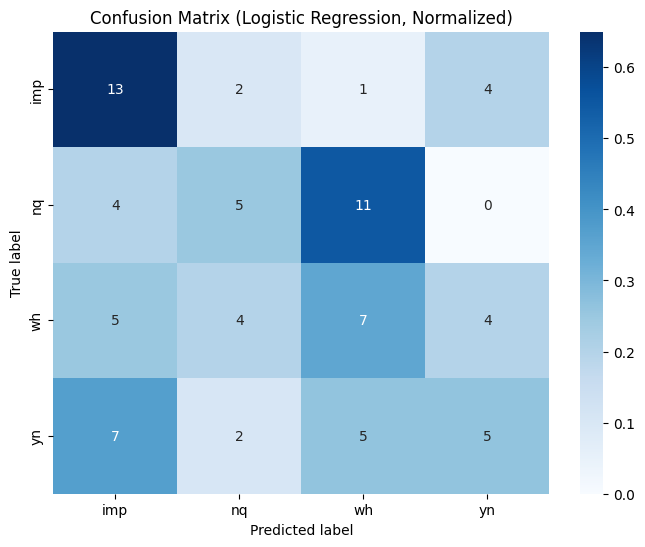

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train the model
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix (Logistic Regression, Normalized)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

3.2 Trainning and data visualization (SVM)

Classification Report:
               precision    recall  f1-score   support

         imp     0.4074    0.5500    0.4681        20
          nq     0.4286    0.1500    0.2222        20
          wh     0.4000    0.5000    0.4444        20
          yn     0.2000    0.2105    0.2051        19

    accuracy                         0.3544        79
   macro avg     0.3590    0.3526    0.3350        79
weighted avg     0.3610    0.3544    0.3366        79



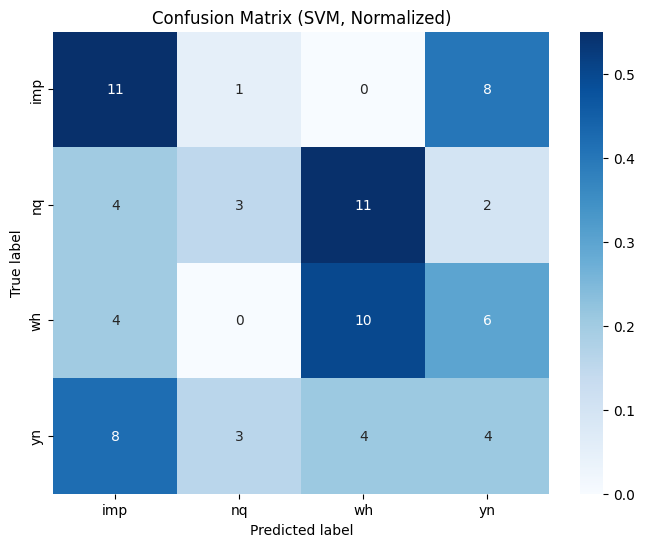

In [10]:
from sklearn.svm import SVC

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train the model
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)

# Normalize confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues',
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title("Confusion Matrix (SVM, Normalized)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

4.1 Perform a 7-fold cross validation (LogisticRegression)

Fold 1 Accuracy: 0.3684
Fold 1 Recall (macro): 0.3726
Fold 1 Confusion Matrix:
[[2 4 2 7]
 [3 6 5 0]
 [3 2 6 3]
 [1 3 3 7]]

Fold 2 Accuracy: 0.3509
Fold 2 Recall (macro): 0.3524
Fold 2 Confusion Matrix:
[[11  0  1  2]
 [ 5  3  6  0]
 [ 5  4  4  2]
 [ 5  3  4  2]]

Fold 3 Accuracy: 0.3158
Fold 3 Recall (macro): 0.3155
Fold 3 Confusion Matrix:
[[8 2 2 2]
 [1 5 4 4]
 [2 4 5 4]
 [5 6 3 0]]

Fold 4 Accuracy: 0.4643
Fold 4 Recall (macro): 0.4643
Fold 4 Confusion Matrix:
[[11  2  0  1]
 [ 2  4  2  6]
 [ 2  1  7  4]
 [ 3  3  4  4]]

Fold 5 Accuracy: 0.4107
Fold 5 Recall (macro): 0.4126
Fold 5 Confusion Matrix:
[[10  2  1  1]
 [ 2  3  8  2]
 [ 4  3  6  1]
 [ 4  1  4  4]]

Fold 6 Accuracy: 0.3571
Fold 6 Recall (macro): 0.3526
Fold 6 Confusion Matrix:
[[11  1  2  0]
 [ 6  5  2  2]
 [ 1  8  3  2]
 [ 7  1  4  1]]

Fold 7 Accuracy: 0.3750
Fold 7 Recall (macro): 0.3710
Fold 7 Confusion Matrix:
[[8 1 3 3]
 [2 6 2 4]
 [4 5 3 2]
 [2 2 5 4]]

Average Accuracy: 0.37746151092015756
Average Recall (macro):

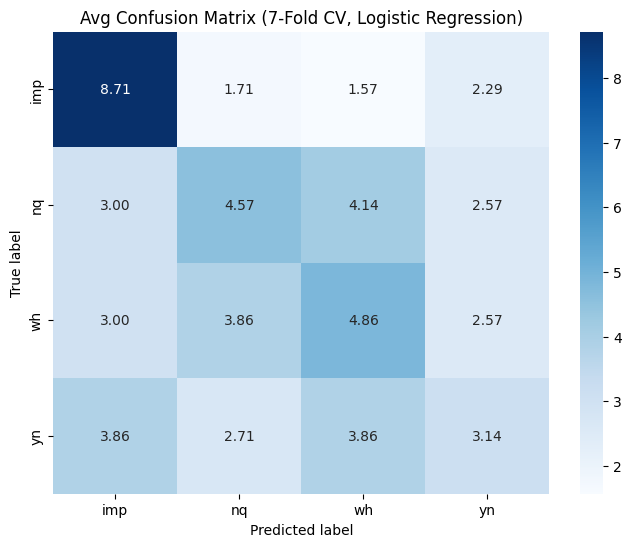

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score

n_splits = 7
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

conf_mats, accuracy_scores, recall_scores = [], [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    clf = LogisticRegression(max_iter=5000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    cm = confusion_matrix(y_val, y_pred)
    conf_mats.append(cm)
    accuracy_scores.append(accuracy_score(y_val, y_pred))
    recall_scores.append(recall_score(y_val, y_pred, average='macro'))

    print(f"Fold {fold} Accuracy: {accuracy_scores[-1]:.4f}")
    print(f"Fold {fold} Recall (macro): {recall_scores[-1]:.4f}")
    print(f"Fold {fold} Confusion Matrix:\n{cm}\n")

# Average metrics
avg_cm = np.mean(conf_mats, axis=0)
avg_acc = np.mean(accuracy_scores)
avg_rec = np.mean(recall_scores)

print("Average Accuracy:", avg_acc)
print("Average Recall (macro):", avg_rec)

plt.figure(figsize=(8, 6))
sns.heatmap(avg_cm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Avg Confusion Matrix (7-Fold CV, Logistic Regression)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

4.2 Perform a 7-fold cross validation (SVM)

Fold 1 Accuracy: 0.3158
Fold 1 Recall (macro): 0.3179
Fold 1 Confusion Matrix:
[[3 3 2 7]
 [3 5 5 1]
 [5 3 5 1]
 [2 2 5 5]]

Fold 2 Accuracy: 0.3509
Fold 2 Recall (macro): 0.3512
Fold 2 Confusion Matrix:
[[12  0  1  1]
 [ 4  2  8  0]
 [ 6  3  5  1]
 [ 6  1  6  1]]

Fold 3 Accuracy: 0.3333
Fold 3 Recall (macro): 0.3310
Fold 3 Confusion Matrix:
[[8 4 1 1]
 [1 3 6 4]
 [2 3 7 3]
 [4 7 2 1]]

Fold 4 Accuracy: 0.3929
Fold 4 Recall (macro): 0.3929
Fold 4 Confusion Matrix:
[[11  2  0  1]
 [ 3  4  1  6]
 [ 3  4  5  2]
 [ 4  2  6  2]]

Fold 5 Accuracy: 0.4286
Fold 5 Recall (macro): 0.4279
Fold 5 Confusion Matrix:
[[11  2  0  1]
 [ 3  4  6  2]
 [ 3  3  6  2]
 [ 5  2  3  3]]

Fold 6 Accuracy: 0.3036
Fold 6 Recall (macro): 0.2988
Fold 6 Confusion Matrix:
[[11  1  2  0]
 [ 7  4  3  1]
 [ 2  9  2  1]
 [ 8  1  4  0]]

Fold 7 Accuracy: 0.3750
Fold 7 Recall (macro): 0.3710
Fold 7 Confusion Matrix:
[[8 3 4 0]
 [4 5 4 1]
 [4 5 4 1]
 [2 2 5 4]]

Average Accuracy: 0.35714285714285715
Average Recall (macro):

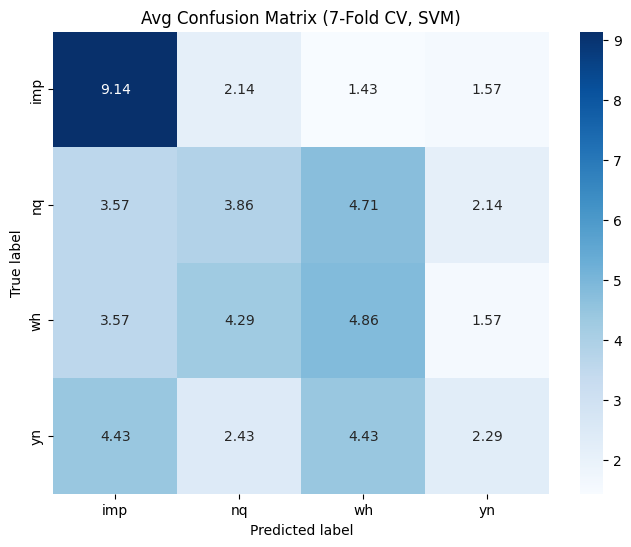

In [12]:
conf_mats, accuracy_scores, recall_scores = [], [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    clf = SVC(kernel='linear', probability=True)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    cm = confusion_matrix(y_val, y_pred)
    conf_mats.append(cm)
    accuracy_scores.append(accuracy_score(y_val, y_pred))
    recall_scores.append(recall_score(y_val, y_pred, average='macro'))

    print(f"Fold {fold} Accuracy: {accuracy_scores[-1]:.4f}")
    print(f"Fold {fold} Recall (macro): {recall_scores[-1]:.4f}")
    print(f"Fold {fold} Confusion Matrix:\n{cm}\n")

# Average metrics
avg_cm = np.mean(conf_mats, axis=0)
avg_acc = np.mean(accuracy_scores)
avg_rec = np.mean(recall_scores)

print("Average Accuracy:", avg_acc)
print("Average Recall (macro):", avg_rec)

plt.figure(figsize=(8, 6))
sns.heatmap(avg_cm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Avg Confusion Matrix (7-Fold CV, SVM)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()